In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from scipy.stats import mode

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        print("complete GPU memory limit setting.")
    except RuntimeError as e:
        print(e)

complete GPU memory limit setting.


In [3]:
BATCH_SIZE = 64
TRAIN_PATH = "cifar/train"
TEST_PATH = "cifar/test"

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(32, 32),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [7]:
ENSEMBLE_NUMBER = 5
models = []
histories = []
for i in range(ENSEMBLE_NUMBER):
    model = Sequential([
                        Conv2D(48, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                        MaxPooling2D(pool_size=(2, 2)),
                        Conv2D(96, (3, 3), activation='relu', padding='same'),
                        MaxPooling2D(pool_size=(2, 2)),
                        Conv2D(192, (3, 3), activation='relu', padding='same'),
                        Conv2D(192, (3, 3), activation='relu', padding='same'),
                        Conv2D(256, (3, 3), activation='relu', padding='same'),
                        MaxPooling2D(pool_size=(2, 2)),
                        BatchNormalization(),
                        Flatten(),
                        Dense(1024, activation='relu'),
                        Dropout(0.5),
                        Dense(512, activation='relu'),
                        Dropout(0.5),
                        Dense(10, activation='softmax') 
                    ])
    model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
                 )
    history = model.fit(
                    train_generator,
                    validation_data=validation_generator,
                    epochs=15,
                    verbose=1,
                    )

    histories.append(history)
    models.append(model)

Epoch 1/15
704/704 [==============================] - 18s 24ms/step - loss: 1.4938 - accuracy: 0.4558 - val_loss: 1.4517 - val_accuracy: 0.4934
Epoch 2/15
704/704 [==============================] - 17s 25ms/step - loss: 1.1192 - accuracy: 0.6053 - val_loss: 1.1700 - val_accuracy: 0.5750
Epoch 3/15
704/704 [==============================] - 17s 24ms/step - loss: 0.9795 - accuracy: 0.6600 - val_loss: 1.0016 - val_accuracy: 0.6542
Epoch 4/15
704/704 [==============================] - 17s 24ms/step - loss: 0.8924 - accuracy: 0.6925 - val_loss: 1.1944 - val_accuracy: 0.5954
Epoch 5/15
704/704 [==============================] - 17s 24ms/step - loss: 0.8221 - accuracy: 0.7162 - val_loss: 1.1080 - val_accuracy: 0.6360
Epoch 6/15
704/704 [==============================] - 17s 24ms/step - loss: 0.7748 - accuracy: 0.7330 - val_loss: 1.1161 - val_accuracy: 0.6338
Epoch 7/15
704/704 [==============================] - 17s 24ms/step - loss: 0.7172 - accuracy: 0.7527 - val_loss: 0.8851 - val_accuracy:

In [9]:
predictions_softVoting = [model.predict(test_generator) for model in models]
ensemble_predictions_softVoting = np.mean(predictions_softVoting, axis=0)

# soft voting 결과로 예측한 클래스
ensemble_predictions_softVoting_classes = np.argmax(ensemble_predictions_softVoting, axis=1)

# 정확도 계산
true_labels = test_generator.classes
soft_voting_accuracy = accuracy_score(true_labels, ensemble_predictions_softVoting_classes)

print(f"Soft Voting Accuracy: {soft_voting_accuracy:.4f}")

157/157 [==============================] - 3s 21ms/step
Soft Voting Accuracy: 0.8097


In [11]:
predictions_hardVoting = [np.argmax(model.predict(test_generator), axis=1) for model in models]

# hard voting을 통해 최빈값을 구해 최종 예측을 결정
ensemble_predicted_hardVoting, _ = mode(predictions_hardVoting, axis=0)

# 정확도 계산
hard_voting_accuracy = accuracy_score(true_labels, ensemble_predicted_hardVoting)

print(f"Hard Voting Accuracy: {hard_voting_accuracy:.4f}")

157/157 [==============================] - 3s 21ms/step
Hard Voting Accuracy: 0.7979


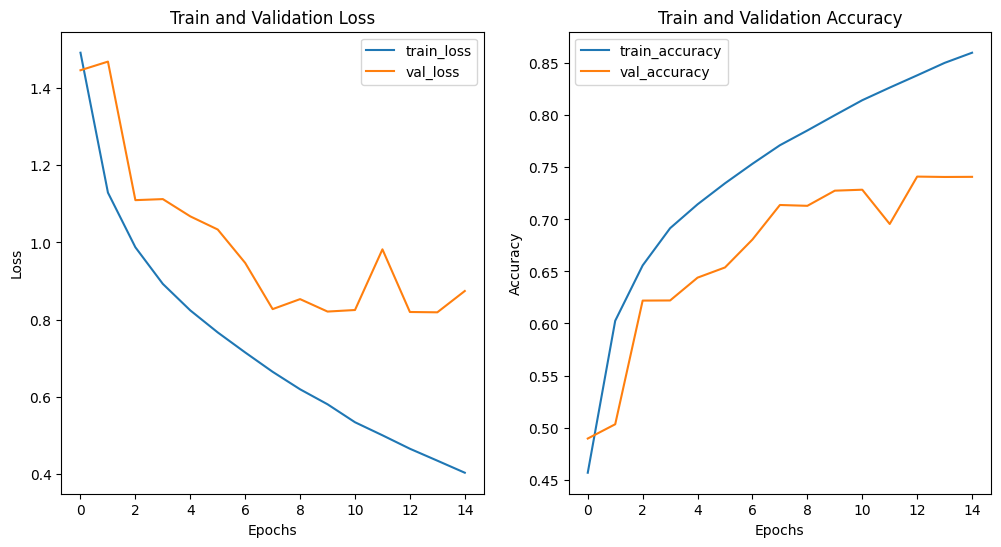

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(np.mean([history.history['loss'] for history in histories], axis=0), label='train_loss')
plt.plot(np.mean([history.history['val_loss'] for history in histories], axis=0), label='val_loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.mean([history.history['accuracy'] for history in histories], axis=0), label='train_accuracy')
plt.plot(np.mean([history.history['val_accuracy'] for history in histories], axis=0), label='val_accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
